<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_23_CNN_Multi_layer_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Multi-Layer Prototype

Based on the [single CNN layer notebook](https://github.com/sv650s/sb-capstone/blob/master/2019-06-23-CNN_prototype.ipynb), we will add a couple convolution layers to see if we get better results

We are using max pooling in this notebook, however, we are only using maxpooling at the end of the CNN layers before the densely connected layers to test for results. In a follow-up notebook we will put max pooling in between CNN layers and see how they perform

Because the previous notebooks were rather large, I put some of the common code for gather metrics and plotting into utility modules that are loaded below

Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py) - plot network history and ROC/AUC graphs
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) - pre-processing and ModelWrapper class
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns


import util.file_util as fu
import util.keras_util as ku
import util.plot_util as pu
import util.dict_util as du


%matplotlib inline
sns.set()


import logging
logging.basicConfig(level=logging.INFO)

DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"



Using TensorFlow backend.


In [0]:
# load data file
df = pd.read_csv(f"{DATA_FILE}")

# extract feature and label columns
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

Same as previous notebooks but consolidated to one cell to make thing easier to understand

Features:
* tokenize our review body - this gives us:
  * vocab size: 40788 words
* then we will pad the sequences to length 186 since this encapsulates 99% of the lenght of our training data

Labels:
* one hot encode our star rating labels (y)


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

# figure out 99% percentile for our max sequence length
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
print(f'Max Sequence Length: {MAX_SEQUENCE_LENGTH}')

# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


## Build Our 2 Layer Model

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [0]:
MODEL_NAME = "CNN_2layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [6]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0730 05:05:44.978373 140065827829632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 05:05:45.003246 140065827829632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 05:05:45.006739 140065827829632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 05:05:45.071680 140065827829632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 05:05:45.127930 140065827829632 deprecation_wrapp

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 100)          90100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 186, 100)          30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               2325250   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total para

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# use our model wrapper the wrap the model so we can save things for later
mw = ku.ModelWrapper(model=model, 
                     name=MODEL_NAME, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE,
                     tokenizer=t,
                     embedding=EMBED_SIZE)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0730 05:05:45.324740 140065827829632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0730 05:05:45.448573 140065827829632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 412s 6ms/step - loss: 0.9330 - acc: 0.6425 - val_loss: 0.8439 - val_acc: 0.6717
Epoch 2/50
67225/67225 [==============================] - 411s 6ms/step - loss: 0.7375 - acc: 0.7089 - val_loss: 0.8489 - val_acc: 0.6719
Epoch 3/50
67225/67225 [==============================] - 411s 6ms/step - loss: 0.6136 - acc: 0.7611 - val_loss: 0.9144 - val_acc: 0.6603
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


## Evaluate our 2 Layer Model

* look at accuracy scores
* epoch vs loss and accuarcy
* confusion matrix
* ROC/AUC plot

In [9]:
# get scores
mw.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

Running model.evaluate...
28011/28011 [==============================] - 41s 1ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 67.70%


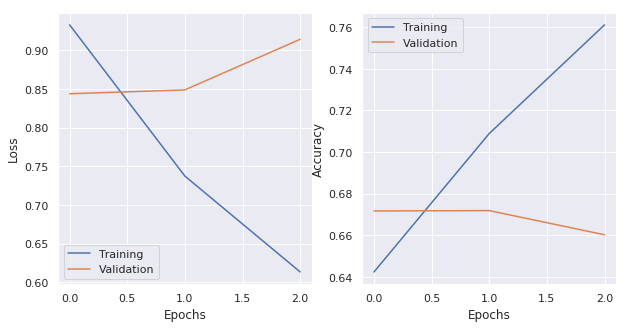

In [10]:
pu.plot_network_history(mw.network_history)

In [11]:
mw.confusion_matrix

array([[ 3324,    39,   217,    48,   340],
       [ 1015,    55,   338,   137,   326],
       [  617,    42,   610,   560,   702],
       [  185,    16,   323,  1193,  3035],
       [  190,    20,   165,   732, 13782]])

In [12]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.62      0.84      0.71      3968
           2       0.32      0.03      0.05      1871
           3       0.37      0.24      0.29      2531
           4       0.45      0.25      0.32      4752
           5       0.76      0.93      0.83     14889

    accuracy                           0.68     28011
   macro avg       0.50      0.46      0.44     28011
weighted avg       0.62      0.68      0.63     28011



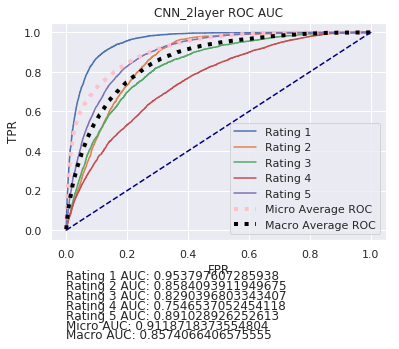

In [13]:
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

## Save off files for our 2 layer model

In [14]:
mw.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_2layer-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_2layer-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_2layer-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


In [15]:
print(datetime.now())

2019-07-30 05:27:55.055498


# Build a 3 Layer CNN with max pooling at the end

In [0]:
MODEL_NAME3 = "CNN_3layer"
# these are same as before
# EMBED_SIZE = 300
# EPOCHS  = 50
# BATCH_SIZE = 128
# VOCAB_SIZE = len(t.word_counts)+1

model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(250, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 186, 100)          90100     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 186, 100)          30100     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 186, 100)          30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 93, 100)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               2325250   
__________

In [18]:
# this is ame as before
# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# use our model wrapper the wrap the model so we can save things for later
mw3 = ku.ModelWrapper(model=model3, 
                     name=MODEL_NAME3, 
                     label_name=LABEL_COLUMN, 
                     tokenizer=t,
                     data_file=DATA_FILE, 
                     embedding=EMBED_SIZE)



network_history3 = mw3.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 488s 7ms/step - loss: 0.9372 - acc: 0.6381 - val_loss: 0.8576 - val_acc: 0.6688
Epoch 2/50
67225/67225 [==============================] - 488s 7ms/step - loss: 0.7495 - acc: 0.7029 - val_loss: 0.8551 - val_acc: 0.6687
Epoch 3/50
67225/67225 [==============================] - 488s 7ms/step - loss: 0.6243 - acc: 0.7545 - val_loss: 0.9536 - val_acc: 0.6682
Epoch 4/50
67225/67225 [==============================] - 490s 7ms/step - loss: 0.5074 - acc: 0.8040 - val_loss: 1.0140 - val_acc: 0.6560
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


## Evaluate our 3 Layer Model

* look at accuracy scores
* epoch vs loss and accuarcy
* confusion matrix
* ROC/AUC plot

In [19]:
# get scores
mw3.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (mw3.scores[1]*100))

Running model.evaluate...
28011/28011 [==============================] - 55s 2ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 67.48%


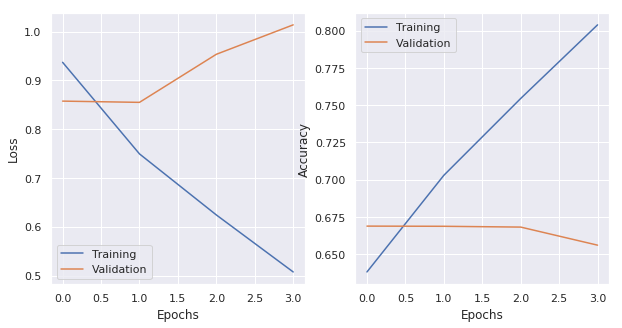

In [20]:
pu.plot_network_history(network_history3)

In [21]:
mw3.confusion_matrix

array([[ 3447,   110,   196,    34,   181],
       [ 1106,   146,   345,    87,   187],
       [  692,   177,   743,   419,   500],
       [  248,    93,   525,  1222,  2664],
       [  343,    60,   292,   850, 13344]])

In [22]:
print(mw3.classification_report)

              precision    recall  f1-score   support

           1       0.59      0.87      0.70      3968
           2       0.25      0.08      0.12      1871
           3       0.35      0.29      0.32      2531
           4       0.47      0.26      0.33      4752
           5       0.79      0.90      0.84     14889

    accuracy                           0.67     28011
   macro avg       0.49      0.48      0.46     28011
weighted avg       0.63      0.67      0.64     28011



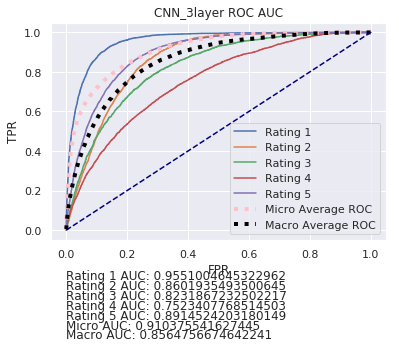

In [23]:
pu.plot_roc_auc(mw3.name, mw3.roc_auc, mw3.fpr, mw3.tpr)

## Save our 3 Layer Model

In [24]:
mw3.save(DRIVE_DIR, append_report=True)
mw3.get_report().to_df()

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.674806,"{""1"": {""precision"": 0.5906442769019876, ""recal...","[[3447, 110, 196, 34, 181], [1106, 146, 345, 8...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,39.1,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.84028,186.0,drive/My Drive/Springboard/capstone/models/ama...,CNN_3layer,<keras.callbacks.History object at 0x7f634cdbb...,39.1,"{""auc_1"": 0.9551004645322962, ""auc_2"": 0.86019...",success,2019-07-30 06:02:28,28011.0,186.0,drive/My Drive/Springboard/capstone/models/dl-...,"{""0"": [0.0, 0.00025201612903225806, 0.00982862...",84032.0,186.0,39.1


In [25]:
print(datetime.now())

2019-07-30 06:02:28.820543


In [26]:
# test saved report
pd.read_csv(mw3.report_file, quotechar="'")

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.677591,"{""1"": {""precision"": 0.5852581521739131, ""recal...","[[3446, 71, 158, 50, 243], [1141, 90, 287, 120...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,32.59,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.835665,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_1layer,<keras.callbacks.History object at 0x7f5403610...,32.59,"{""auc_1"": 0.9527249533513878, ""auc_2"": 0.86096...",success,2019-07-30 01:46:31,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.0078125,...",84032.0,186.0,32.59
1,0.679019,"{""1"": {""precision"": 0.6480066102045032, ""recal...","[[3137, 62, 476, 40, 253], [843, 60, 603, 132,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,8.79,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.823435,186.0,drive/My Drive/Springboard/capstone/models/ama...,biGRU_1layer_attention,<keras.callbacks.History object at 0x7f6df2f58...,8.79,"{""auc_1"": 0.9540099546947473, ""auc_2"": 0.86369...",success,2019-07-30 01:51:39,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01058467...",84032.0,186.0,8.79
2,0.668990,"{""1"": {""precision"": 0.6134569850039463, ""recal...","[[3109, 147, 201, 93, 325], [911, 128, 310, 19...",review_body-word2vec5-111909-512-nolda-DNN_384...,word2vec,17.84,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846571,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_384_384,<keras.callbacks.History object at 0x7fab83bd1...,17.84,"{""auc_1"": 0.9488228396143968, ""auc_2"": 0.85419...",success,2019-07-30 01:58:04,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,17.84
3,0.667918,"{""1"": {""precision"": 0.5995067349649023, ""recal...","[[3160, 127, 223, 80, 285], [972, 119, 316, 18...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,6.92,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846016,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128_batchnorm,<keras.callbacks.History object at 0x7f62cd50f...,6.92,"{""auc_1"": 0.949632140558062, ""auc_2"": 0.854176...",success,2019-07-30 02:08:19,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,6.92
4,0.676877,"{""1"": {""precision"": 0.6334449478038211, ""recal...","[[3216, 54, 297, 67, 334], [947, 52, 436, 176,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,13.37,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.830913,186.0,drive/My Drive/Springboard/capstone/models/ama...,biGRU_2layer_attention,<keras.callbacks.History object at 0x7f469db69...,13.37,"{""auc_1"": 0.9543024780953614, ""auc_2"": 0.86158...",success,2019-07-30 02:17:58,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.00806451...",84032.0,186.0,13.37
5,0.672771,"{""1"": {""precision"": 0.635506519558676, ""recall...","[[3168, 179, 251, 41, 329], [877, 178, 379, 10...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,19.33,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.851762,186.0,drive/My Drive/Springboard/capstone/models/ama...,LSTM_1layer,<keras.callbacks.History object at 0x7f141a65a...,19.33,"{""auc_1"": 0.949565040265559, ""auc_2"": 0.854623...",success,2019-07-30 02:31:38,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"

# Compare our 2 models

In [27]:
print(mw.name)
print(f"accuracy: {mw.scores[1]}\n")
print(mw3.name)
print(f"accuracy: {mw3.scores[1]}\n")


CNN_2layer
accuracy: 0.6770197422398626

CNN_3layer
accuracy: 0.6748063260925641



In [29]:
print(mw.name)
print(mw.confusion_matrix)
print()
print(mw3.name)
print(mw3.confusion_matrix)


CNN_2layer
[[ 3324    39   217    48   340]
 [ 1015    55   338   137   326]
 [  617    42   610   560   702]
 [  185    16   323  1193  3035]
 [  190    20   165   732 13782]]

CNN_3layer
[[ 3447   110   196    34   181]
 [ 1106   146   345    87   187]
 [  692   177   743   419   500]
 [  248    93   525  1222  2664]
 [  343    60   292   850 13344]]


In [31]:
print(mw.name)
print(mw.classification_report)
print()
print(mw3.name)
print(mw3.classification_report)

CNN_2layer
              precision    recall  f1-score   support

           1       0.62      0.84      0.71      3968
           2       0.32      0.03      0.05      1871
           3       0.37      0.24      0.29      2531
           4       0.45      0.25      0.32      4752
           5       0.76      0.93      0.83     14889

    accuracy                           0.68     28011
   macro avg       0.50      0.46      0.44     28011
weighted avg       0.62      0.68      0.63     28011


CNN_3layer
              precision    recall  f1-score   support

           1       0.59      0.87      0.70      3968
           2       0.25      0.08      0.12      1871
           3       0.35      0.29      0.32      2531
           4       0.47      0.26      0.33      4752
           5       0.79      0.90      0.84     14889

    accuracy                           0.67     28011
   macro avg       0.49      0.48      0.46     28011
weighted avg       0.63      0.67      0.64     28011


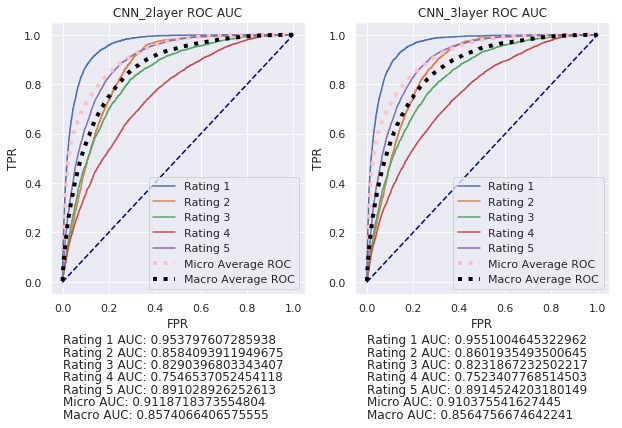

In [34]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, figure=fig)
fig.add_subplot(gs[0, 0])
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)
fig.add_subplot(gs[0, 1])
pu.plot_roc_auc(mw3.name, mw3.roc_auc, mw3.fpr, mw3.tpr)


# Conclusion

Neither models are doing great on the star rating 2 area. 3 layer architecture is a lot more liberal at identifying star rating 2's, however, it's at the expense of precision. It identifies a lot more star 2 ratings, however, it also misclassified a lot more as rating 2. If you look at the confusion matrix, 2 layer arhitecture only classified 172 as star rating 2 - out of which only 55 were correct (32% correct), but 3 layer architecture classified 586 as star ratiing 2 but only 146 were correctly classified (25%)

This is a general trend for the 3 layer architecture. In general recall is higher in the 3 layer architecture in almost all ratings except for 5, however, precision is slightly slower than the 2 layer architecture.

For star rating 4 - this is another one of our problem classes. 3 layer architecture seems to be doing better in both precision and recall.

When looking at AUC - the numbers are pretty similar with 3 layer having slightly higher AUC for ratings 1, 2, and 5 but slightly lower for the rest. The difference is less than 1%.